# 2. Minimize
The initial structure is likely in a unstable state. We need to minimize the potential energy to relax the structure.

In this tutorial, we choose to use [AIREBO](https://doi.org/10.1063/1.481208) force field. This force field is good for carbon-based materials and hydrocarbons.

## 2.1 Copy files
- AIREBO force field "CH.airebo" is copied from local "Potential" folder for LAMMPS.
- We need to copy "data.lmp" from "1. Structure" folder.

In [1]:
from pathlib import Path
from shutil import copy
cwd = Path.cwd()
source = cwd.parent/'1. Structure'

copy(source/'data.lmp', cwd)

'c:\\Users\\fitbe\\OneDrive\\Desktop\\PKA Tutorial\\LAMMPS\\2. Minimize\\data.lmp'

## 2.2 Input file
In this input file, we will perform the very first simulation, i.e., minimization.

The initilization is the same as before. For structure, we use `read_data`. For force field, pair_style `airebo` is easy to set up.

In simulation, we have several steps.
1. Determine what properties we want to monitor. `thermo` is an easy way to output global properties such as density, lattice constant, and potential energy. Other useful commands are `compute` and `variable`. `dump` outputs the trajactory frames so OVITO can read and render. 
2. Determine what kind of simulation we want to perform. `fix` tells LAMMPS that. In this case, we call `fix box/relax` to allow box size to change during minimization.
3. Run the simulation. Besides `minimize` for minimization, most of the time, `run` is used to tell how long we want to simulate.
4. Output the new structure as "data.new.lmp" for next chapter.

In [2]:
%%writefile in.lmp
#---------- Initization ----------#
units metal
dimension 3
boundary p p p
atom_style atomic

#---------- structure ----------#
read_data data.lmp

#---------- Force Field ----------#
pair_style airebo 3.0
pair_coeff * * CH.airebo C H

#---------- Simulation ----------#
# Thermo
thermo 1
thermo_style custom step pe lx ly lz density press

# Dump
dump 1 all custom 1 dump.lmp mass type id x y z element
dump_modify 1 element C H

# Relax box
fix 1 all box/relax iso 0.0 vmax 0.001 fixedpoint 0 0 0

# Minimize
min_style cg
minimize 1.0e-10 1.0e-10 1000 10000

#---------- End ----------#
write_data data.new.lmp

Overwriting in.lmp


## 2.3. Run LAMMPS

In [3]:
!lmp -i in.lmp -l log.lmp

LAMMPS (2 Aug 2023 - Update 1)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from C:\Users\fitbe\AppData\Local\LAMMPS 64-bit 2Aug2023 with GUI\plugins
Reading data file ...
  orthogonal box = (0 0 0) to (26.84 27.78 25.6)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  2880 atoms
  reading velocities ...
  2880 velocities
  read_data CPU = 0.015 seconds
Reading airebo potential file CH.airebo with DATE: 2011-10-25
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 12.2
  ghost atom cutoff = 12.2
  binsize = 6.1, bins = 5 5 5
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair airebo, perpetual
      attributes: full, newton on, ghost
      pair build: full/bin/ghost
      stencil: full/ghost/bin/3d
      bin: standard
Setting up cg style minimization ...
  Unit style   

## 2.4. Visualize the structure
Open the "dump.lmp" using OVITO software. You should see how the box size changes.

## 2.5. Log file
After each simulation, a log file like "log.lmp" is produced. It contains the settings, outputs, or errors for the simulation. Of course, we can open the text file directly. 

Most of the time, we want to load the outputs and plot it. LAMMPS has a useful python package called `lammps.formats`. The documentation can be found at https://docs.lammps.org/Python_formats.html. Next, we will demontrate how to load and plot the potential energy and density during minimization.

In [4]:
# Import packages
from lammps.formats import LogFile
import pandas as pd

C:\Users\fitbe\AppData\Local\Temp\ipykernel_100132\3674864415.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# Load log file
file = LogFile(filename='log.lmp')

# The file contains a list of runs and errors. We only have one run.
# Each run is a dictionary with thermo fields as keys, storing the values over time.
run = file.runs[0]

# Convert to pandas DataFrame
log = pd.DataFrame(run)

# Print
log

Step     PotEng         Lx         Ly         Lz   Density         Press
0      0.0 -12277.854  26.840000  27.780000  25.600000  1.171374  17160.166000
1      1.0 -12278.394  26.866840  27.807780  25.625600  1.167867  12862.251000
2      2.0 -12278.783  26.893680  27.835560  25.651200  1.164374   8624.037200
3      3.0 -12279.024  26.920520  27.863340  25.676800  1.160895   4445.257000
4      4.0 -12279.123  26.947360  27.891120  25.702400  1.157430    326.322810
..     ...        ...        ...        ...        ...       ...           ...
176  176.0 -12301.652  27.237815  28.191747  25.979436  1.120796      5.160051
177  177.0 -12301.660  27.244856  28.199035  25.986151  1.119927   -193.238250
178  178.0 -12301.661  27.243588  28.197723  25.984942  1.120083     -0.051773
179  179.0 -12301.663  27.243040  28.197155  25.984420  1.120151     -7.633448
180  180.0 -12301.663  27.242954  28.197066  25.984337  1.120162      4.257039

[181 rows x 7 columns]

<Axes: xlabel='Step', ylabel='Potential Energy (eV)'>

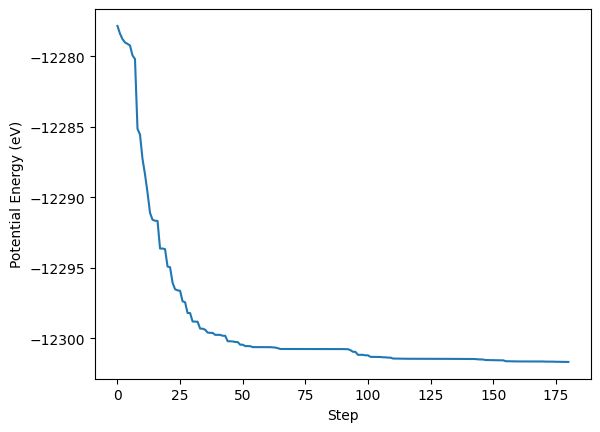

In [6]:
# Plot the potential energy
log.plot(x='Step', y='PotEng', ylabel='Potential Energy (eV)', legend=False)

<Axes: xlabel='Step', ylabel='Density (g/cm^3)'>

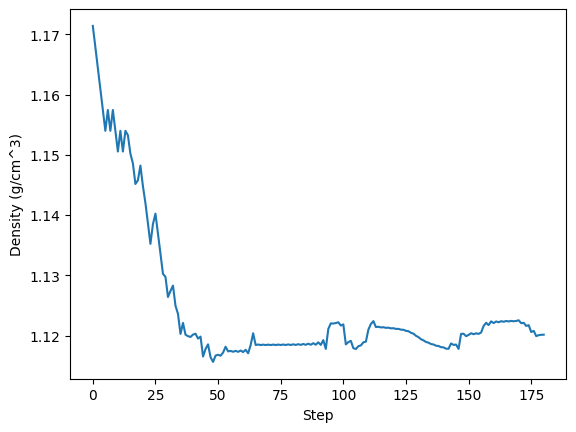

In [7]:
# Plot the density
log.plot(x='Step', y='Density', ylabel='Density (g/cm^3)', legend=False)

## 2.6 Summarize
At this stage, we have successfully performed the very first molecular dynamics simulation.
We create the structure and perform an energy minimization (box size can change).

The basic flowchart for a LAMMPS input file is shown:
- Initilization
- Structure
- Force Field
- Simulation

We also know how to visualize the output structure using OVITO.

We have a basic idea of the log file and know how to load and plot the properties we are interested in.